# Term Paper 2 - Visualizations

## Importing Libraries, Data and setting up

In [1]:
import xarray as xr
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path


In [2]:
# paths
data_path = Path('../../data/')
log_path = Path('../../runs/')
figure_path = Path('../../LaTex/figures/')

In [3]:
# function to reduce plotting resolution
def coarsen(da: xr.DataArray, factor: int = 10, reduction: str = 'mean') -> xr.DataArray:
    return getattr(da.coarsen(x=factor, y=factor, boundary='trim'), reduction)().compute()

# function to smooth metrics
def smooth_data(data, window_size=5):
        return np.convolve(data, np.ones(window_size)/window_size, mode='valid')


## Visualizations of the available Data

### Size of the 3 areas

In [4]:
# import .shp file
gdf = gpd.read_file(data_path / 'BL_QA_editedJK.shp')


In [5]:
# group df by area and summarize Shape_Area by sum
gdf_grouped = gdf.groupby('area').agg({'Shape_Area': 'sum'}).reset_index()
gdf_grouped


,area,Shape_Area
0,industrial,132641.574903
1,residential,83487.396389
2,rural,82739.756797


### Available data per label

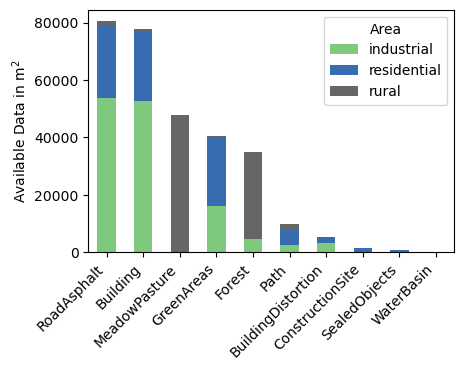

In [6]:
fig_filename = 'area_by_category.pdf'
image_size_cm = [12, 8]

fig, ax = plt.subplots(figsize=(image_size_cm[0]/2.54, image_size_cm[1]/2.54))

# Aggregate the grouped data
data = gdf.groupby(['QA_categor', 'area'])['Shape_Area'].sum().unstack().fillna(0)

# Sort the data by the total size of each QA_categor
data['Total'] = data.sum(axis=1)
data = data.sort_values('Total', ascending=False).drop(columns='Total')

# Plot stacked bar chart
data.plot(kind='bar', stacked=True, ax=ax, colormap='Accent')

ax.set_xlabel(None)
ax.set_ylabel('Available Data in m$^2$')
ax.legend(title='Area')

# Rotate x-axis labels by 45 degrees
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

plt.savefig(figure_path / fig_filename, bbox_inches='tight')
plt.show()


## Visualizations of the Results

### Loss and accuracy

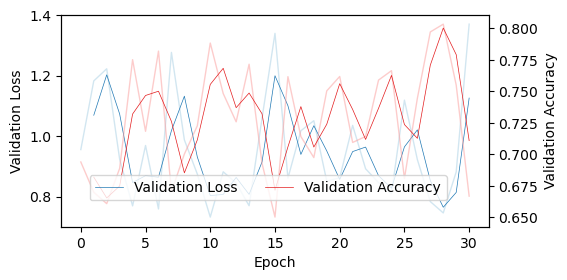

In [22]:
run = 'noaugment_complete'
metrics = pd.read_csv(log_path / run / 'metrics.csv')
image_size_cm = [14, 7]

validation_data = metrics[~metrics['valid_loss'].isnull()]

# Smooth the data
smoothed_val_loss = smooth_data(validation_data['valid_loss'], window_size=2)
smoothed_val_acc = smooth_data(validation_data['valid_acc'], window_size=2)

# Adjust the epoch range to match the length of the smoothed data
epochs = validation_data['epoch'][len(validation_data['epoch']) - len(smoothed_val_loss):]

fig, ax1 = plt.subplots(figsize=(image_size_cm[0]/2.54, image_size_cm[1]/2.54))

# Plot unsmoothed valid_loss on the primary y-axis
ax1.plot(validation_data['epoch'], validation_data['valid_loss'], color='#A6CEE3', label='', linewidth=1, alpha=0.5)
# Plot smoothed valid_loss on the primary y-axis
ax1.plot(epochs, smoothed_val_loss, color='#1F78B4', label='Validation Loss', linewidth=0.5)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Validation Loss')
ax1.tick_params(axis='y')

# Create a secondary y-axis to plot valid_acc
ax2 = ax1.twinx()
# Plot unsmoothed valid_acc on the secondary y-axis
ax2.plot(validation_data['epoch'], validation_data['valid_acc'], color='#FB9A99', label='', linewidth=1, alpha=0.5)
# Plot smoothed valid_acc on the secondary y-axis
ax2.plot(epochs, smoothed_val_acc, color='#E31A1C', label='Validation Accuracy', linewidth=0.5)
ax2.set_ylabel('Validation Accuracy')
ax2.tick_params(axis='y')

# Combine legends from both axes
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
fig.legend(lines_1 + lines_2, labels_1 + labels_2, loc='lower center', bbox_to_anchor=(0.5, 0.18), ncol=2)


### Visualizations of the Predictions

In [29]:
run = 'noaugment_complete'

ds_training = xr.open_zarr(data_path / 'combined.zarr')
ds_predictions = xr.open_zarr(log_path / run / 'preds.zarr')

areas = gpd.read_file(data_path / 'AOI_Labeled.shp')

In [27]:
ds_training["label"] = ds_training["label"].where(ds_training["label"] != 255, np.nan)


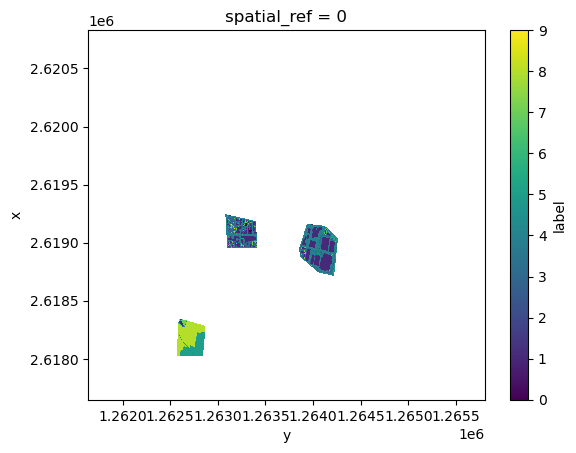

In [28]:
coarsen(ds_training["label"]).plot(vmin=0, vmax=9)

In [35]:
print(ds_training["mask"])

<xarray.DataArray 'mask' (x: 31815, y: 41651)> Size: 1GB
dask.array<open_dataset-mask, shape=(31815, 41651), dtype=uint8, chunksize=(31815, 500), chunktype=numpy.ndarray>
Coordinates:
    spatial_ref  int64 8B ...
  * x            (x) float64 255kB 2.618e+06 2.618e+06 ... 2.621e+06 2.621e+06
  * y            (y) float64 333kB 1.266e+06 1.266e+06 ... 1.262e+06 1.262e+06


In [36]:
print(ds_training)

<xarray.Dataset> Size: 13GB
Dimensions:      (band: 4, x: 31815, y: 41651)
Coordinates:
  * band         (band) int64 32B 1 2 3 4
    spatial_ref  int64 8B ...
  * x            (x) float64 255kB 2.618e+06 2.618e+06 ... 2.621e+06 2.621e+06
  * y            (y) float64 333kB 1.266e+06 1.266e+06 ... 1.262e+06 1.262e+06
Data variables:
    label        (x, y) uint8 1GB dask.array<chunksize=(500, 500), meta=np.ndarray>
    mask         (x, y) uint8 1GB dask.array<chunksize=(31815, 500), meta=np.ndarray>
    rs           (band, x, y) uint16 11GB dask.array<chunksize=(4, 500, 500), meta=np.ndarray>
Attributes:
    creator:  Julian Kraft


NameError: name 'unique' is not defined